Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hashlib
from sklearn.metrics import classification_report, confusion_matrix
#from modeling import ResNet50_CBAM
#from CLAHE import CLAHE
from torchvision.models import resnet50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(torch.cuda.get_device_name(0))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

c:\Users\Daniel Crispalito\anaconda3\envs\torch5050\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
NVIDIA GeForce RTX 5050 Laptop GPU


# Exploratory Data Analysis

In [2]:
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
base_dataset_path = os.path.join(path, 'DATASET')

train_dir = os.path.join(base_dataset_path, "train")
test_dir = os.path.join(base_dataset_path, "test")

NUM_CLASSES = os.listdir(train_dir).__len__()

EMOTION_MAP = {1: 'Surprise', 2: 'Fear', 3: 'Disgust', 4: 'Happiness', 5: 'Sadness', 6: 'Anger', 7: 'Neutral'} #mapping masing" class

train_df = pd.read_csv(os.path.join(path, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(path, "test_labels.csv"))

train_df['image_full_path'] = train_df.apply(lambda row: os.path.join(train_dir, str(row['label']), row['image']), axis=1)
test_df['image_full_path'] = test_df.apply(lambda row: os.path.join(test_dir, str(row['label']), row['image']), axis=1)

In [3]:
print(f"Jumlah Data Training: {train_df.shape[0]}")
print(f"Jumlah Data Testing: {test_df.shape[0]}")

Jumlah Data Training: 12271
Jumlah Data Testing: 3068


In [4]:
print("Jumlah Kelas : ", NUM_CLASSES)
print("Jenis Kelas : ")
for cls in os.listdir(train_dir):
    print(f" - {cls} {EMOTION_MAP[int(cls)]}")

Jumlah Kelas :  7
Jenis Kelas : 
 - 1 Surprise
 - 2 Fear
 - 3 Disgust
 - 4 Happiness
 - 5 Sadness
 - 6 Anger
 - 7 Neutral


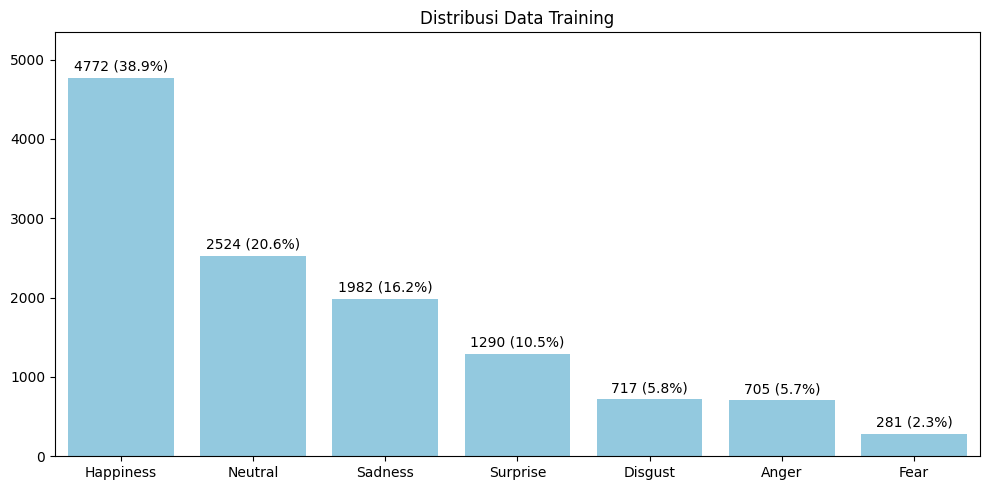

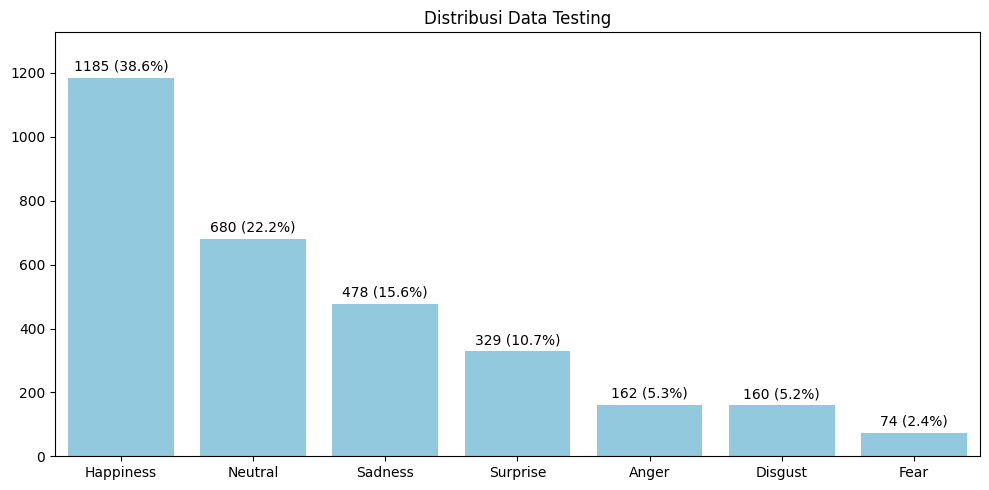

In [5]:
def plot_distribution(df, title):
    plt.figure(figsize=(10, 5))
    
    temp_series = df['label'].map(EMOTION_MAP)
    
    ax = sns.countplot(x=temp_series, order=temp_series.value_counts().index, color='skyblue')
    ax.set(title=title, xlabel="", ylabel="")
    ax.margins(y=0.12)

    for container in ax.containers:
        labels = [f'{int(h)} ({h/len(temp_series)*100:.1f}%)' for h in container.datavalues]
        ax.bar_label(container, labels=labels, padding=3)

    plt.tight_layout()
    plt.show()

plot_distribution(train_df, "Distribusi Data Training")
plot_distribution(test_df, "Distribusi Data Testing")

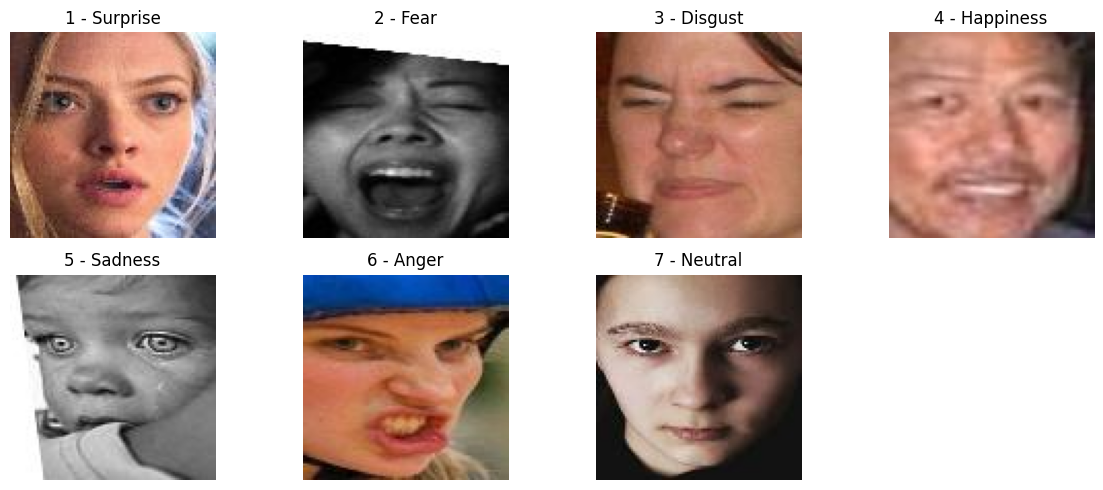

In [6]:
def plot_sample_images_per_class(df, samples_per_class=1):
    class_ids = sorted(df["label"].unique())
    
    plt.figure(figsize=(12, 5))
    
    for i, cid in enumerate(class_ids):
        subset = df[df["label"] == cid].sample(samples_per_class, random_state=42)
        
        for j, row in enumerate(subset.itertuples()):
            try:
                img = Image.open(row.image_full_path).convert("RGB")
            except Exception as e:
                print("Gagal load:", row.image_full_path, e)
                continue
            
            plt.subplot(2, 4, i + 1)
            plt.imshow(img)
            plt.title(f"{cid} - {EMOTION_MAP[int(cid)]}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_sample_images_per_class(train_df, samples_per_class=1)

In [7]:
widths, heights, ratios = [], [], []

for p in train_df["image_full_path"]:
    try:
        img = Image.open(p)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        ratios.append(w/h)
    except:
        continue

print("Rata-rata ukuran (WxH):", (np.mean(widths), np.mean(heights)))
print("Min size:", (min(widths), min(heights)))
print("Max size:", (max(widths), max(heights)))
print("Rata-rata aspect ratio:", np.mean(ratios)) 

Rata-rata ukuran (WxH): (np.float64(100.0), np.float64(100.0))
Min size: (100, 100)
Max size: (100, 100)
Rata-rata aspect ratio: 1.0


In [8]:
rgb_count, gray_count = 0, 0

for p in train_df["image_full_path"]:
    try:
        img = Image.open(p)
        if img.mode == "RGB":
            rgb_count += 1
        elif img.mode in ["L", "LA", "P"]:
            gray_count += 1
    except:
        continue

print("Total RGB images:", rgb_count)
print("Total Grayscale-like images:", gray_count)

Total RGB images: 12269
Total Grayscale-like images: 0


In [9]:
corrupt_files = []

for p in train_df["image_full_path"]:
    try:
        img = Image.open(p)
        img.verify()  # akan error kalau corrupt
    except Exception as e:
        corrupt_files.append((p, str(e)))

print("Total file corrupt:", len(corrupt_files))
for f, err in corrupt_files[:5]:
    print("Corrupt:", f, "| Error:", err)


Total file corrupt: 2
Corrupt: C:\Users\Daniel Crispalito\.cache\kagglehub\datasets\shuvoalok\raf-db-dataset\versions\2\DATASET\train\4\train_03285_aligned.jpg | Error: [Errno 2] No such file or directory: 'C:\\Users\\Daniel Crispalito\\.cache\\kagglehub\\datasets\\shuvoalok\\raf-db-dataset\\versions\\2\\DATASET\\train\\4\\train_03285_aligned.jpg'
Corrupt: C:\Users\Daniel Crispalito\.cache\kagglehub\datasets\shuvoalok\raf-db-dataset\versions\2\DATASET\train\6\train_08540_aligned.jpg | Error: [Errno 2] No such file or directory: 'C:\\Users\\Daniel Crispalito\\.cache\\kagglehub\\datasets\\shuvoalok\\raf-db-dataset\\versions\\2\\DATASET\\train\\6\\train_08540_aligned.jpg'


In [10]:
hashes = {}
duplicates = []

for p in train_df["image_full_path"]:
    try:
        with open(p, "rb") as f:
            img_hash = hashlib.md5(f.read()).hexdigest()
        if img_hash in hashes:
            duplicates.append(p)
        else:
            hashes[img_hash] = p
    except:
        continue

print("Total duplikasi:", len(duplicates))
for d in duplicates[:5]:
    print("Duplicate:", d)


Total duplikasi: 0


# Preprocessing Images

In [11]:
#hapus row duplicates

for p in duplicates:
    if os.path.exists(p):
        os.remove(p)
        print("Deleted from disk:", p)

#hapus file corrupt
for p, _ in corrupt_files:
    if os.path.exists(p):
        os.remove(p)
        print("Deleted from disk:", p)

train_df = train_df[~train_df["image_full_path"].isin(duplicates)]
train_df = train_df[~train_df["image_full_path"].isin([f for f, _ in corrupt_files])]
print("Sisa data setelah hapus duplikasi di DataFrame:", len(train_df))

Sisa data setelah hapus duplikasi di DataFrame: 12269


In [12]:
class RAFDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(row.image_full_path).convert("RGB")
        label = row.label - 1
        if self.transform:
            image = self.transform(image)
        return image, label

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #CLAHE(clip_limit=2.0, grid_size=8), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #CLAHE(clip_limit=2.0, grid_size=8),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:
val_df, test_df = train_test_split(
    test_df, 
    test_size=0.5, 
    random_state=42,
    stratify=test_df['label'] 
)


train_dataset = RAFDataset(train_df, transform=train_transform)
val_dataset = RAFDataset(val_df, transform=test_transform)
test_dataset = RAFDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Models

#### Convolutional Block Attention Module

In [15]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(x_cat)
        return self.sigmoid(out) * x

class CBAMBlock(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        out = self.channel_attention(x)
        out = self.spatial_attention(out)
        return out


#### ResNet-50 + CBAM

In [16]:
class ResNet50_LightCBAM(nn.Module):
    def __init__(self, num_classes=7): 
        super().__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # CBAM hanya di block terakhir layer4
        last_block = self.resnet.layer4[-1]
        self.resnet.layer4[-1] = nn.Sequential(
            last_block,
            CBAMBlock(last_block.conv3.out_channels)
        )

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self,x):
        return self.resnet(x)


# Training Models

Step 1 : Freeze

In [17]:
model = ResNet50_LightCBAM(num_classes=NUM_CLASSES)
model = model.to(device)
EPOCH_t1 = 10  
EPOCH_t2 = 70 
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
PATH = "best_resnet50_cbam.pth"

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print(f"Starting Stage 1 ({EPOCH_t1} Epochs) - Training FC Layer Only")

for param in model.resnet.parameters():
    param.requires_grad = False
for param in model.resnet.fc.parameters():
    param.requires_grad = True


for epoch in range(EPOCH_t1):
    # train phase
    model.train()
    train_loss, train_corrects, train_total = 0.0, 0, 0
    
    train_loop = tqdm(train_loader, desc=f"S1-Epoch {epoch+1}/{EPOCH_t1} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_total += labels.size(0)
        train_loop.set_postfix(loss=train_loss/train_total, acc=(train_corrects.double()/train_total).item())

    # EVal phase
    model.eval()
    val_loss, val_corrects, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    # Simpan Stats
    epoch_train_loss = train_loss / train_total
    epoch_train_acc = (train_corrects.double() / train_total).item()
    epoch_val_loss = val_loss / val_total
    epoch_val_acc = (val_corrects.double() / val_total).item()

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"[S1-Epoch {epoch+1}] Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # Save Best Model
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), PATH)

Starting Stage 1 (10 Epochs) - Training FC Layer Only


[S1-Epoch 1] Train Loss: 1.5146 Acc: 0.4297 | Val Loss: 1.4084 Acc: 0.4648


[S1-Epoch 2] Train Loss: 1.3868 Acc: 0.4849 | Val Loss: 1.3215 Acc: 0.5091


[S1-Epoch 3] Train Loss: 1.3475 Acc: 0.5015 | Val Loss: 1.2921 Acc: 0.5052


[S1-Epoch 4] Train Loss: 1.3197 Acc: 0.5089 | Val Loss: 1.2674 Acc: 0.5293


[S1-Epoch 5] Train Loss: 1.2908 Acc: 0.5228 | Val Loss: 1.2630 Acc: 0.5248


[S1-Epoch 6] Train Loss: 1.2896 Acc: 0.5185 | Val Loss: 1.2848 Acc: 0.5209


[S1-Epoch 7] Train Loss: 1.2784 Acc: 0.5299 | Val Loss: 1.2634 Acc: 0.5254


[S1-Epoch 8] Train Loss: 1.2714 Acc: 0.5309 | Val Loss: 1.2908 Acc: 0.5261


[S1-Epoch 9] Train Loss: 1.2619 Acc: 0.5354 | Val Loss: 1.2419 Acc: 0.5482


[S1-Epoch 10] Train Loss: 1.2645 Acc: 0.5348 | Val Loss: 1.2539 Acc: 0.5404


Step 2 : Unfreeze to train all layer

In [ ]:

patience = 10  
trigger_times = 0

print(f"\nStarting Stage 2 ({EPOCH_t2} Epochs) - Fine-tuning All Layers")

model.load_state_dict(torch.load(PATH))
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(EPOCH_t2):
    # --- TRAINING PHASE ---
    model.train()
    train_loss, train_corrects, train_total = 0.0, 0, 0
    train_loop = tqdm(train_loader, desc=f"S2-Epoch {epoch+1}/{EPOCH_t2} [Train]", leave=False)
    
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_total += labels.size(0)
        train_loop.set_postfix(loss=train_loss/train_total, acc=(train_corrects.double()/train_total).item())

    # --- EVALUATION PHASE ---
    model.eval()
    val_loss, val_corrects, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)

    # Simpan Stats
    epoch_val_acc = (val_corrects.double() / val_total).item()
    
    history['train_loss'].append(train_loss / train_total)
    history['train_acc'].append((train_corrects.double() / train_total).item())
    history['val_loss'].append(val_loss / val_total)
    history['val_acc'].append(epoch_val_acc)

    print(f"[S2-Epoch {epoch+1}] Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # --- LOGIKA EARLY STOPPING & SAVE BEST ---
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), PATH)
        print(f"--> Bobot terbaik disimpan: {best_acc:.4f}")
        trigger_times = 0 # Reset counter jika ada kenaikan
    else:
        trigger_times += 1
        print(f"--> No improvement ({trigger_times}/{patience})")
        
        if trigger_times >= patience:
            print(f"\n[Early Stopping] Training dihentikan pada epoch {epoch+1}!")
            break

print(f"\nTraining Selesai! Akurasi terbaik yang didapat: {best_acc:.4f}")


Starting Stage 2 (70 Epochs) - Fine-tuning All Layers


[S2-Epoch 1] Train Acc: 0.6146 | Val Acc: 0.6708
--> Bobot terbaik disimpan: 0.6708


[S2-Epoch 2] Train Acc: 0.7095 | Val Acc: 0.7125
--> Bobot terbaik disimpan: 0.7125


[S2-Epoch 3] Train Acc: 0.7623 | Val Acc: 0.7516
--> Bobot terbaik disimpan: 0.7516


[S2-Epoch 4] Train Acc: 0.8034 | Val Acc: 0.7679
--> Bobot terbaik disimpan: 0.7679


[S2-Epoch 5] Train Acc: 0.8262 | Val Acc: 0.7725
--> Bobot terbaik disimpan: 0.7725


[S2-Epoch 6] Train Acc: 0.8564 | Val Acc: 0.7797
--> Bobot terbaik disimpan: 0.7797


[S2-Epoch 7] Train Acc: 0.8784 | Val Acc: 0.7894
--> Bobot terbaik disimpan: 0.7894


[S2-Epoch 8] Train Acc: 0.9008 | Val Acc: 0.8018
--> Bobot terbaik disimpan: 0.8018


[S2-Epoch 9] Train Acc: 0.9156 | Val Acc: 0.7992
--> No improvement (1/10)


[S2-Epoch 10] Train Acc: 0.9293 | Val Acc: 0.7947
--> No improvement (2/10)


[S2-Epoch 11] Train Acc: 0.9379 | Val Acc: 0.7934
--> No improvement (3/10)


[S2-Epoch 12] Train Acc: 0.9557 | Val Acc: 0.7914
--> No improvement (4/10)


[S2-Epoch 13] Train Acc: 0.9643 | Val Acc: 0.8051
--> Bobot terbaik disimpan: 0.8051


[S2-Epoch 14] Train Acc: 0.9688 | Val Acc: 0.8064
--> Bobot terbaik disimpan: 0.8064


[S2-Epoch 15] Train Acc: 0.9698 | Val Acc: 0.8025
--> No improvement (1/10)


[S2-Epoch 16] Train Acc: 0.9764 | Val Acc: 0.7953
--> No improvement (2/10)


[S2-Epoch 17] Train Acc: 0.9797 | Val Acc: 0.8096
--> Bobot terbaik disimpan: 0.8096


[S2-Epoch 18] Train Acc: 0.9817 | Val Acc: 0.7881
--> No improvement (1/10)


[S2-Epoch 19] Train Acc: 0.9818 | Val Acc: 0.7979
--> No improvement (2/10)


[S2-Epoch 20] Train Acc: 0.9835 | Val Acc: 0.7966
--> No improvement (3/10)


[S2-Epoch 21] Train Acc: 0.9826 | Val Acc: 0.8018
--> No improvement (4/10)


[S2-Epoch 22] Train Acc: 0.9870 | Val Acc: 0.8038
--> No improvement (5/10)


[S2-Epoch 23] Train Acc: 0.9861 | Val Acc: 0.8083
--> No improvement (6/10)


[S2-Epoch 24] Train Acc: 0.9883 | Val Acc: 0.8005
--> No improvement (7/10)


[S2-Epoch 25] Train Acc: 0.9879 | Val Acc: 0.8005
--> No improvement (8/10)


[S2-Epoch 26] Train Acc: 0.9874 | Val Acc: 0.8005
--> No improvement (9/10)


[S2-Epoch 27] Train Acc: 0.9900 | Val Acc: 0.8044
--> No improvement (10/10)

[Early Stopping] Training dihentikan pada epoch 27!

Training Selesai! Akurasi terbaik yang didapat: 0.8096


Train loss and accuracy vs validation loss and accuracy

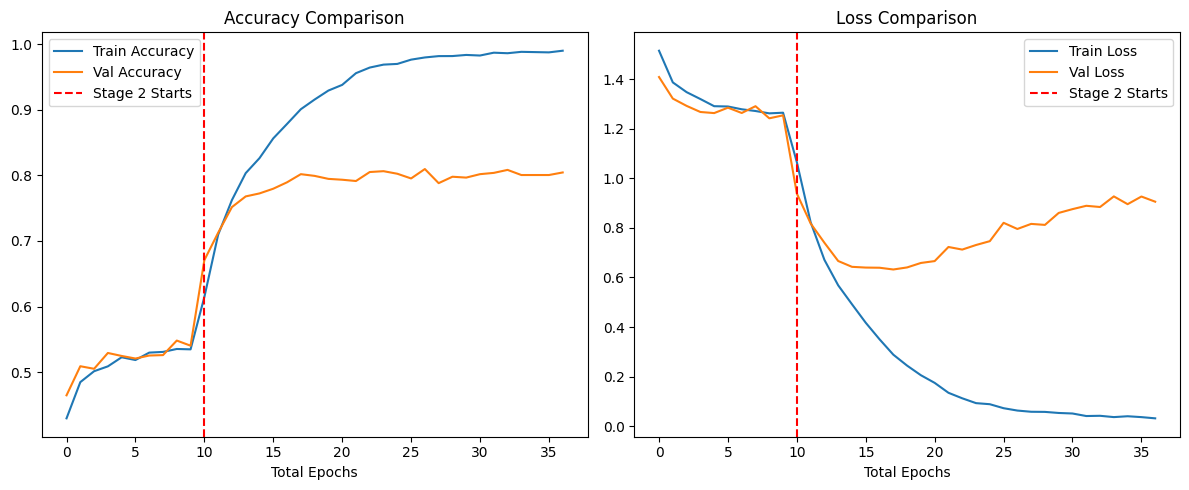

In [20]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.axvline(x=EPOCH_t1, color='r', linestyle='--', label='Stage 2 Starts')
plt.title('Accuracy Comparison')
plt.xlabel('Total Epochs')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.axvline(x=EPOCH_t1, color='r', linestyle='--', label='Stage 2 Starts')
plt.title('Loss Comparison')
plt.xlabel('Total Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation 

Loaded weights from: best_resnet50_cbam.pth
Starting evaluation on test set...


Testing: 100%|██████████| 48/48 [00:10<00:00,  4.40it/s]



TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Surprise       0.80      0.87      0.83       165
        Fear       0.56      0.51      0.54        37
     Disgust       0.56      0.46      0.51        80
   Happiness       0.92      0.92      0.92       592
     Sadness       0.84      0.75      0.79       239
       Anger       0.69      0.73      0.71        81
     Neutral       0.76      0.81      0.79       340

    accuracy                           0.82      1534
   macro avg       0.73      0.72      0.73      1534
weighted avg       0.82      0.82      0.82      1534



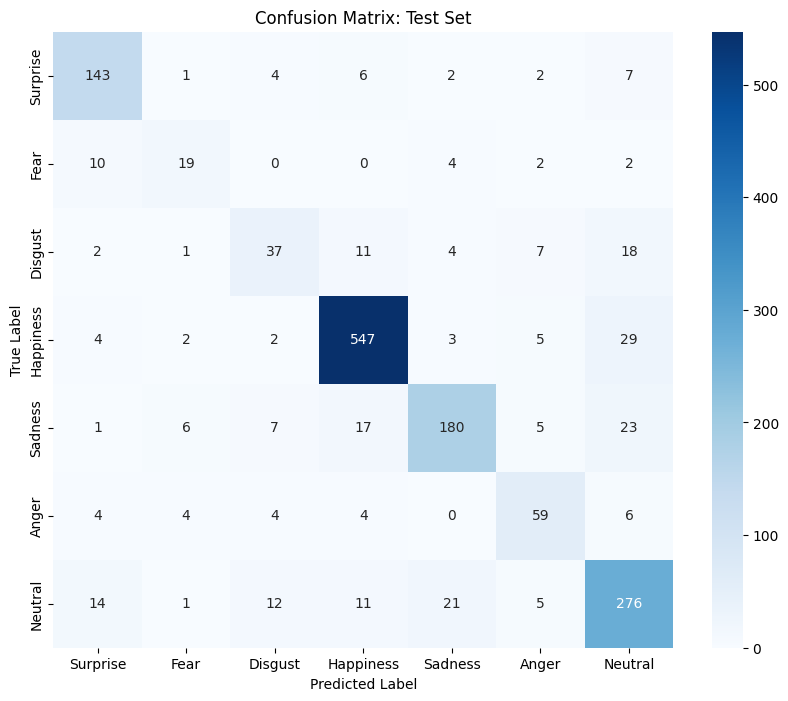

In [23]:
def evaluate_on_test_set(model, test_loader, device, class_names, model_path=None):
    if model_path:
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded weights from: {model_path}")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Starting evaluation on test set...")
    
    # 2. Proses testing tanpa menghitung gradient
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 3. Print Classification Report
    print("\n" + "="*30)
    print("TEST SET CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 4. Visualisasi Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Test Set')
    plt.show()

class_names = [EMOTION_MAP[i] for i in sorted(EMOTION_MAP.keys())]
evaluate_on_test_set(
    model=model, 
    test_loader=test_loader, 
    device=device, 
    class_names=class_names, 
    model_path=PATH
)

Visualize Wrong Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.1461596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.0262864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7521569..2.2489083].


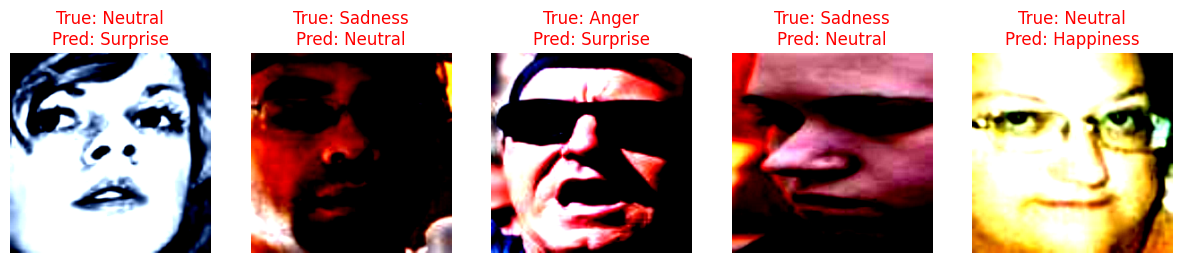

In [ ]:
def visualize_errors(model, test_loader, device, class_names, num_images=5):
    model.eval()
    errors = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]
            for idx in wrong_idx:
                if len(errors) < num_images:
                    errors.append((images[idx].cpu(), labels[idx].item(), preds[idx].item()))
                else:
                    break
    
    plt.figure(figsize=(15, 5))
    for i, (img, true_label, pred_label) in enumerate(errors):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray' if img.shape[0]==1 else None)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color='red')
        plt.axis('off')
    plt.show()

visualize_errors(model, test_loader, device, class_names)